## 1. Imports and Setup

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from scipy.stats import entropy
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 2. Data Loading and Preprocessing

Following the methodology in Section 3.1:
- Apply transformation codes (T-codes) for stationarity
- Standardize each series to zero mean and unit variance

In [3]:
def transform_series(x, tcode):
    '''
    Transform the time series according to FRED-MD T-codes.
    
    T-codes:
    1: level (no transformation)
    2: first difference
    3: second difference
    4: log level
    5: log first difference
    6: log second difference
    7: percent change
    '''
    if tcode == 1:
        return x
    elif tcode == 2:
        return x.diff()
    elif tcode == 3:
        return x.diff().diff()
    elif tcode == 4:
        return np.log(x)
    elif tcode == 5:
        return np.log(x).diff()
    elif tcode == 6:
        return np.log(x).diff().diff()
    elif tcode == 7:
        return x.pct_change()
    else:
        raise ValueError(f"Unknown tcode: {tcode}")


def load_and_preprocess_data(filepath="macro_dataset.csv", start_date="1962-08-01"):
    '''
    Load FRED-MD data, apply transformations, and standardize.
    '''
    data = pd.read_csv(filepath, skiprows=[1], index_col=0)
    data.columns = [c.upper() for c in data.columns]
    
    data = data.loc[pd.notna(data.index), :]
    data.index = pd.date_range(start="1959-01-01", freq="MS", periods=len(data))
    
    tcodes = pd.read_csv(filepath, nrows=1, index_col=0)
    tcodes.columns = [c.upper() for c in tcodes.columns]
    
    data = data.apply(lambda x: transform_series(x, tcodes[x.name].item()))
    
    start = pd.Timestamp(start_date)
    data = data.dropna(axis=1, subset=[start])
    data = data.fillna(method='ffill').dropna()
    
    # Standardize each series (Section 3.1)
    scaler = StandardScaler()
    data_standardized = pd.DataFrame(
        scaler.fit_transform(data),
        index=data.index,
        columns=data.columns
    )
    
    return data_standardized, data


# Load data
df_standardized, df_raw = load_and_preprocess_data()
print(f"Dataset shape: {df_standardized.shape}")
print(f"Date range: {df_standardized.index[0]} to {df_standardized.index[-1]}")
print(f"Number of features: {df_standardized.shape[1]}")

Dataset shape: (760, 122)
Date range: 1962-07-01 00:00:00 to 2025-10-01 00:00:00
Number of features: 122


In [4]:
df_standardized.head(10)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLX,RETAILX,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSX
1962-07-01,0.190332,0.382186,0.074047,-0.648921,0.696730,0.817033,0.825300,1.043552,1.500706,0.605726,...,-0.725116,-0.208612,-0.514893,1.082759,0.871106,1.949090,-0.192078,-0.102867,-0.416127,0.039132
1962-08-01,-0.080265,-0.202574,0.021537,1.759356,0.090380,-0.081436,-0.175951,-0.364563,-1.237633,-0.486692,...,-0.189426,0.921956,-0.059023,-0.006822,-1.310432,-0.008473,-0.027190,0.011025,-0.299954,-0.497671
1962-09-01,-0.175851,-0.191146,1.067028,-1.528882,-0.114371,0.474607,0.486564,0.235619,0.485377,0.339293,...,0.225057,1.405331,-0.115593,-1.082811,0.434224,-0.976522,-0.697402,-0.418921,0.247259,-0.139462
1962-10-01,0.227106,0.150943,-0.954141,1.483340,0.688135,-0.082255,-0.506689,-0.064628,-0.326125,0.073761,...,-1.687266,-2.253100,0.281417,-0.002291,-0.433587,0.963907,0.425151,0.134451,1.304363,0.948028
1962-11-01,0.093463,0.385854,1.331551,0.722374,0.027219,0.249147,0.484492,0.233890,0.482825,-0.024658,...,1.537831,0.378226,0.223842,1.073736,0.863674,-0.972266,0.175581,0.200386,-1.670646,-0.359594
1962-12-01,0.177573,0.462562,0.371225,-2.542736,-0.317032,-0.192972,-0.066278,0.132974,0.278459,0.170384,...,-0.218697,-0.350370,-0.285614,-1.078318,-0.005555,-0.004180,-0.382914,0.140567,1.145687,-0.656326
1963-01-01,0.300243,-0.768069,-0.365906,0.937013,-0.037158,0.576411,0.914183,1.211438,1.073325,0.265128,...,-0.343437,0.947284,1.012942,1.069280,-1.285176,0.959689,0.042374,-0.521630,-0.475203,-0.633886
1963-02-01,-0.658978,0.041920,-0.802313,0.886454,-0.786326,1.005187,0.688418,0.613143,0.960666,0.261769,...,1.125719,-0.452135,-1.131381,-0.006710,0.856343,-0.008361,-0.050343,-0.046989,-1.239380,-0.816004
1963-03-01,0.163388,0.338056,0.305992,-0.940396,0.202566,0.454410,-0.175951,-0.067661,0.267457,0.006185,...,-0.248279,-0.637584,-0.227211,-0.006674,0.423995,-0.008325,0.134642,0.070427,0.086831,-0.984848
1963-04-01,0.014725,0.073089,0.125302,1.657232,-0.029010,0.770915,1.001115,0.317678,0.266126,0.195109,...,-0.366519,0.293449,0.166911,-1.065061,-2.560540,-0.959721,0.447154,0.350921,0.304164,-1.084896


In [5]:
X = df_standardized.values
dates = df_standardized.index
T, p = X.shape
print(f"Data matrix X: {T} time periods x {p} features")

Data matrix X: 760 time periods x 122 features


In [6]:
K = 4
print(f"Number of regimes K = {K}")

Number of regimes K = 4


## 4. Clustering Methods Implementation

### 4.1 Fuzzy C-Means Clustering

Minimizes the objective function (Equation 1):
$$\min_{\{c_i\}, \{w_{i,t}\}} \sum_{t=1}^{T} \sum_{i=1}^{K} w_{i,t}^m \|x_t - c_i\|^2$$

subject to $\sum_{i=1}^{K} w_{i,t} = 1$ and $w_{i,t} \geq 0$.

In [7]:
class FuzzyCMeans:
    """
    Fuzzy C-Means clustering (Section 4.1)
    
    Parameters:
    -----------
    n_clusters : int
        Number of clusters (K)
    m : float
        Fuzziness parameter (m > 1). Higher values make assignments softer.
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance
    """
    
    def __init__(self, n_clusters=4, m=2.0, max_iter=300, tol=1e-6, random_state=42):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centers_ = None
        self.membership_ = None
        
    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Initialize membership matrix randomly
        U = np.random.rand(n_samples, self.n_clusters)
        U = U / U.sum(axis=1, keepdims=True)  # Normalize rows to sum to 1
        
        for iteration in range(self.max_iter):
            U_old = U.copy()
            
            # Update centroids
            Um = U ** self.m
            self.centers_ = (Um.T @ X) / Um.sum(axis=0, keepdims=True).T
            
            # Update membership matrix
            distances = cdist(X, self.centers_, metric='euclidean')
            distances = np.maximum(distances, 1e-10)  # Avoid division by zero
            
            # Fuzzy membership update (Equation 1 derivative)
            power = 2 / (self.m - 1)
            U = 1 / (distances ** power)
            U = U / U.sum(axis=1, keepdims=True)
            
            # Check convergence
            if np.linalg.norm(U - U_old) < self.tol:
                break
        
        self.membership_ = U
        return self
    
    def predict_proba(self, X):
        """Return soft membership weights w_{i,t}"""
        distances = cdist(X, self.centers_, metric='euclidean')
        distances = np.maximum(distances, 1e-10)
        power = 2 / (self.m - 1)
        U = 1 / (distances ** power)
        return U / U.sum(axis=1, keepdims=True)
    
    def predict(self, X):
        """Return hard labels (argmax of membership)"""
        return np.argmax(self.predict_proba(X), axis=1)

In [8]:
# Fit Fuzzy C-Means
fcm = FuzzyCMeans(n_clusters=K, m=2.0, random_state=42)
fcm.fit(X)

# Get soft and hard assignments
fcm_soft = fcm.predict_proba(X)  # w_t = (w_{1,t}, ..., w_{K,t})
fcm_hard = fcm.predict(X)  # R_t = argmax_i w_{i,t}

print("Fuzzy C-Means clustering complete.")
print(f"Membership weights shape: {fcm_soft.shape}")
print(f"Sample membership for first 5 periods:")
print(pd.DataFrame(fcm_soft[:5], columns=[f'Regime {i+1}' for i in range(K)]))

Fuzzy C-Means clustering complete.
Membership weights shape: (760, 4)
Sample membership for first 5 periods:
   Regime 1  Regime 2  Regime 3  Regime 4
0      0.25      0.25      0.25      0.25
1      0.25      0.25      0.25      0.25
2      0.25      0.25      0.25      0.25
3      0.25      0.25      0.25      0.25
4      0.25      0.25      0.25      0.25


### 4.2 Modified K-Means (Oliveira et al., 2025)

Two-step variant:
1. Classify periods as "typical" or "atypical" based on distance from cluster centers
2. Run k-means on typical months with probability assignment step

In [9]:
class ModifiedKMeans:
    """
    Modified K-Means clustering (Section 4.2, Oliveira et al., 2025)
    """
    
    def __init__(self, n_clusters=4, atypical_threshold=2.0, random_state=42):
        self.n_clusters = n_clusters
        self.atypical_threshold = atypical_threshold  # Standard deviations for atypical detection
        self.random_state = random_state
        self.kmeans_ = None
        self.centers_ = None
        self.atypical_mask_ = None
        
    def fit(self, X):
        n_samples = X.shape[0]
        
        # Step 1: Initial k-means to detect atypical periods
        initial_kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        initial_labels = initial_kmeans.fit_predict(X)
        
        # Calculate distances to assigned cluster centers
        distances_to_center = np.array([
            np.linalg.norm(X[i] - initial_kmeans.cluster_centers_[initial_labels[i]])
            for i in range(n_samples)
        ])
        
        # Identify atypical periods (outliers)
        mean_dist = distances_to_center.mean()
        std_dist = distances_to_center.std()
        self.atypical_mask_ = distances_to_center > (mean_dist + self.atypical_threshold * std_dist)
        
        # Step 2: Re-run k-means on typical periods only
        typical_indices = ~self.atypical_mask_
        X_typical = X[typical_indices]
        
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        self.kmeans_.fit(X_typical)
        self.centers_ = self.kmeans_.cluster_centers_
        
        return self
    
    def predict_proba(self, X):
        """
        Return probability distribution over regimes based on inverse distances.
        Similar to fuzzy clustering but post-hoc.
        """
        distances = cdist(X, self.centers_, metric='euclidean')
        distances = np.maximum(distances, 1e-10)
        
        # Inverse distance weighting (softmax-like)
        inv_distances = 1 / distances
        probs = inv_distances / inv_distances.sum(axis=1, keepdims=True)
        
        return probs
    
    def predict(self, X):
        """Return hard labels"""
        return np.argmax(self.predict_proba(X), axis=1)
    
    def get_atypical_periods(self):
        """Return mask of atypical periods"""
        return self.atypical_mask_

In [10]:
# Fit Modified K-Means
mkm = ModifiedKMeans(n_clusters=K, atypical_threshold=2.0, random_state=42)
mkm.fit(X)

# Get soft and hard assignments
mkm_soft = mkm.predict_proba(X)
mkm_hard = mkm.predict(X)

print(f"Number of atypical periods: {mkm.atypical_mask_.sum()} ({100*mkm.atypical_mask_.mean():.1f}%)")
print(pd.DataFrame(mkm_soft[:5], columns=[f'Regime {i+1}' for i in range(K)]))

Number of atypical periods: 31 (4.1%)
   Regime 1  Regime 2  Regime 3  Regime 4
0  0.024794  0.308158  0.381337  0.285711
1  0.025806  0.304085  0.342985  0.327124
2  0.023363  0.305183  0.369445  0.302009
3  0.029530  0.307207  0.337472  0.325792
4  0.026592  0.302538  0.360084  0.310786


### 4.3 Vanilla K-Means with Probabilistic Assignment

Standard k-means with soft assignment derived from inverse distances (Section 4.3):
$$d_{i,t} = \|x_t - c_i\|, \quad u_{i,t} = \frac{1}{d_{i,t} + \epsilon}, \quad w_{i,t} = \frac{u_{i,t}}{\sum_{j=1}^{K} u_{j,t}}$$

In [11]:
class VanillaKMeansProb:
    """
    Vanilla K-Means with probabilistic assignment (Section 4.3)
    """
    
    def __init__(self, n_clusters=4, epsilon=1e-10, random_state=42):
        self.n_clusters = n_clusters
        self.epsilon = epsilon
        self.random_state = random_state
        self.kmeans_ = None
        self.centers_ = None
        
    def fit(self, X):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        self.kmeans_.fit(X)
        self.centers_ = self.kmeans_.cluster_centers_
        return self
    
    def predict_proba(self, X):
        """
        Return soft assignment based on inverse distances (Equation in Section 4.3).
        """
        distances = cdist(X, self.centers_, metric='euclidean')
        u = 1 / (distances + self.epsilon)
        w = u / u.sum(axis=1, keepdims=True)
        return w
    
    def predict(self, X):
        """Return hard labels from k-means"""
        return self.kmeans_.predict(X)

In [12]:
# Fit Vanilla K-Means
vkm = VanillaKMeansProb(n_clusters=K, random_state=42)
vkm.fit(X)

# Get soft and hard assignments
vkm_soft = vkm.predict_proba(X)
vkm_hard = vkm.predict(X)

print("Vanilla K-Means with probabilistic assignment complete.")
print(f"Sample membership for first 5 periods:")
print(pd.DataFrame(vkm_soft[:5], columns=[f'Regime {i+1}' for i in range(K)]))

Vanilla K-Means with probabilistic assignment complete.
Sample membership for first 5 periods:
   Regime 1  Regime 2  Regime 3  Regime 4
0  0.265880  0.320098  0.388457  0.025566
1  0.295414  0.321576  0.356411  0.026599
2  0.267896  0.325183  0.382852  0.024069
3  0.340688  0.298719  0.331198  0.029396
4  0.281843  0.317774  0.373003  0.027381


### 4.4 Gaussian Mixture Model (GMM)

Model-based clustering assuming data is from a mixture of K multivariate Gaussians (Section 4.4):
$$p(x_t) = \sum_{i=1}^{K} \pi_i \phi(x_t; \mu_i, \Sigma_i)$$

Soft assignment is the posterior responsibility:
$$w_{i,t} = \Pr(R_t = i | x_t) = \frac{\pi_i \phi(x_t; \mu_i, \Sigma_i)}{\sum_{j=1}^{K} \pi_j \phi(x_t; \mu_j, \Sigma_j)}$$

In [13]:
# Fit GMM
# Use diagonal covariance to handle high dimensionality
gmm = GaussianMixture(
    n_components=K,
    covariance_type='diag',  # Use diagonal covariance for numerical stability
    random_state=42,
    n_init=10,
    max_iter=200
)
gmm.fit(X)

# Get soft and hard assignments
gmm_soft = gmm.predict_proba(X)  # Posterior probabilities
gmm_hard = gmm.predict(X)

print("Gaussian Mixture Model clustering complete.")
print(f"Mixing proportions: {gmm.weights_}")
print(f"Sample membership for first 5 periods:")
print(pd.DataFrame(gmm_soft[:5], columns=[f'Regime {i+1}' for i in range(K)]))

Gaussian Mixture Model clustering complete.
Mixing proportions: [0.04467606 0.19484343 0.38129848 0.37918203]
Sample membership for first 5 periods:
       Regime 1      Regime 2      Regime 3      Regime 4
0  4.333029e-55  3.375083e-23  6.722466e-21  1.000000e+00
1  4.546563e-47  3.621709e-13  1.087640e-06  9.999989e-01
2  3.699270e-54  5.344947e-21  1.614538e-07  9.999998e-01
3  5.018086e-42  2.815370e-06  9.999967e-01  4.458805e-07
4  3.195073e-48  5.725492e-15  1.136055e-09  1.000000e+00


### 4.5 Markov-Switching Model

Regime-switching model with Markov chain state transitions (Section 4.5):
$$\Pr(S_{t+1} = j | S_t = i) = \Pi_{ij}$$

We use PCA to reduce dimensionality before fitting the MS model.

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

In [15]:
class MarkovSwitchingClustering:
    """
    Markov-Switching model for regime detection (Section 4.5)

    Uses first few principal components for tractability.
    """

    def __init__(self, n_regimes=4, n_components=3, random_state=42):
        self.n_regimes = n_regimes
        self.n_components = n_components
        self.random_state = random_state
        self.pca_ = None
        self.model_ = None
        self.results_ = None
        self.transition_matrix_ = None
        self._n_samples = None

    def fit(self, X, dates):
        np.random.seed(self.random_state)
        self._n_samples = X.shape[0]

        # Reduce dimensionality with PCA
        self.pca_ = PCA(n_components=self.n_components)
        X_pca = self.pca_.fit_transform(X)

        df_pca = pd.DataFrame(X_pca, index=dates, columns=[f'PC{i+1}' for i in range(self.n_components)])

        # Fit Markov-switching autoregression on first principal component
        y = df_pca['PC1']

        self.model_ = MarkovAutoregression(
            y,
            k_regimes=self.n_regimes,
            order=1,
            switching_ar=False,
            switching_variance=True
        )
        self.results_ = self.model_.fit(search_reps=20, maxiter=500)
        
        # Get transition matrix - handle different statsmodels versions
        if hasattr(self.results_, 'regime_transition'):
            trans = self.results_.regime_transition
            if hasattr(trans, 'values'):
                trans = trans.values
            else:
                trans = np.array(trans)

            trans = np.squeeze(trans)
            if trans.ndim == 2:
                self.transition_matrix_ = trans
            else:
                probs = self.results_.smoothed_marginal_probabilities.values
                hard_states = np.argmax(probs, axis=1)
                self.transition_matrix_ = self._estimate_transition_matrix(hard_states)
        else:
            probs = self.results_.smoothed_marginal_probabilities.values
            hard_states = np.argmax(probs, axis=1)
            self.transition_matrix_ = self._estimate_transition_matrix(hard_states)


        self._smoothed_probs = self.results_.smoothed_marginal_probabilities.values
        # Ensure we have correct shape (T x K)
        if self._smoothed_probs.shape[0] != self._n_samples:

            n_missing = self._n_samples - self._smoothed_probs.shape[0]
            if n_missing > 0:
                padding = np.tile(self._smoothed_probs[0], (n_missing, 1))
                self._smoothed_probs = np.vstack([padding, self._smoothed_probs])

        else:
            self._fit_gmm_markov(X, dates)

        return self

    def _fit_gmm_markov(self, X, dates):
        """
        Fallback: Use GMM for state assignment and estimate transition matrix empirically.
        """
        # Fit GMM
        gmm = GaussianMixture(n_components=self.n_regimes, covariance_type='diag',
                             random_state=self.random_state, n_init=10)
        gmm.fit(X)

        # Get state probabilities
        self._gmm = gmm
        self._smoothed_probs = gmm.predict_proba(X)
        self._hard_states = gmm.predict(X)

        # Estimate transition matrix from hard states
        self.transition_matrix_ = self._estimate_transition_matrix(self._hard_states)

    def _estimate_transition_matrix(self, states):
        """Estimate transition matrix from state sequence"""
        n_states = self.n_regimes
        trans_counts = np.zeros((n_states, n_states))

        for t in range(len(states) - 1):
            trans_counts[states[t], states[t+1]] += 1

        # Normalize rows
        row_sums = trans_counts.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        trans_matrix = trans_counts / row_sums

        return trans_matrix

    def predict_proba(self, X):
        """Return smoothed state probabilities"""
        return self._smoothed_probs

    def predict(self, X):
        """Return most likely states (Viterbi-like)"""
        return np.argmax(self.predict_proba(X), axis=1)

In [16]:
# Fit Markov-Switching Model
ms = MarkovSwitchingClustering(n_regimes=K, n_components=3, random_state=42)
ms.fit(X, dates)

# Get soft and hard assignments
ms_soft = ms.predict_proba(X)
ms_hard = ms.predict(X)

print("Markov-Switching Model clustering complete.")
print(f"Soft probabilities shape: {ms_soft.shape}")
print(f"\nTransition Matrix:")
# Ensure transition matrix is the right size
tm = ms.transition_matrix_
if tm.shape[0] == K:
    print(pd.DataFrame(tm, 
                       index=[f'From R{i+1}' for i in range(K)],
                       columns=[f'To R{i+1}' for i in range(K)]).round(3))
else:
    print(f"Transition matrix shape: {tm.shape}")
    print(tm.round(3))

Markov-Switching Model clustering complete.
Soft probabilities shape: (760, 4)

Transition Matrix:
         To R1  To R2  To R3  To R4
From R1  0.956  0.125  0.011  0.243
From R2  0.016  0.827  0.025  0.000
From R3  0.028  0.048  0.961  0.000
From R4  0.000  0.000  0.003  0.756


In [17]:
methods = ['Fuzzy C-Means', 'Modified K-Means', 'Vanilla K-Means', 'GMM', 'Markov-Switching']

soft_assignments = {
    'Fuzzy C-Means': fcm_soft,
    'Modified K-Means': mkm_soft,
    'Vanilla K-Means': vkm_soft,
    'GMM': gmm_soft,
    'Markov-Switching': ms_soft
}

hard_assignments = {
    'Fuzzy C-Means': fcm_hard,
    'Modified K-Means': mkm_hard,
    'Vanilla K-Means': vkm_hard,
    'GMM': gmm_hard,
    'Markov-Switching': ms_hard
}

## 6. Visualization of Regime Assignments

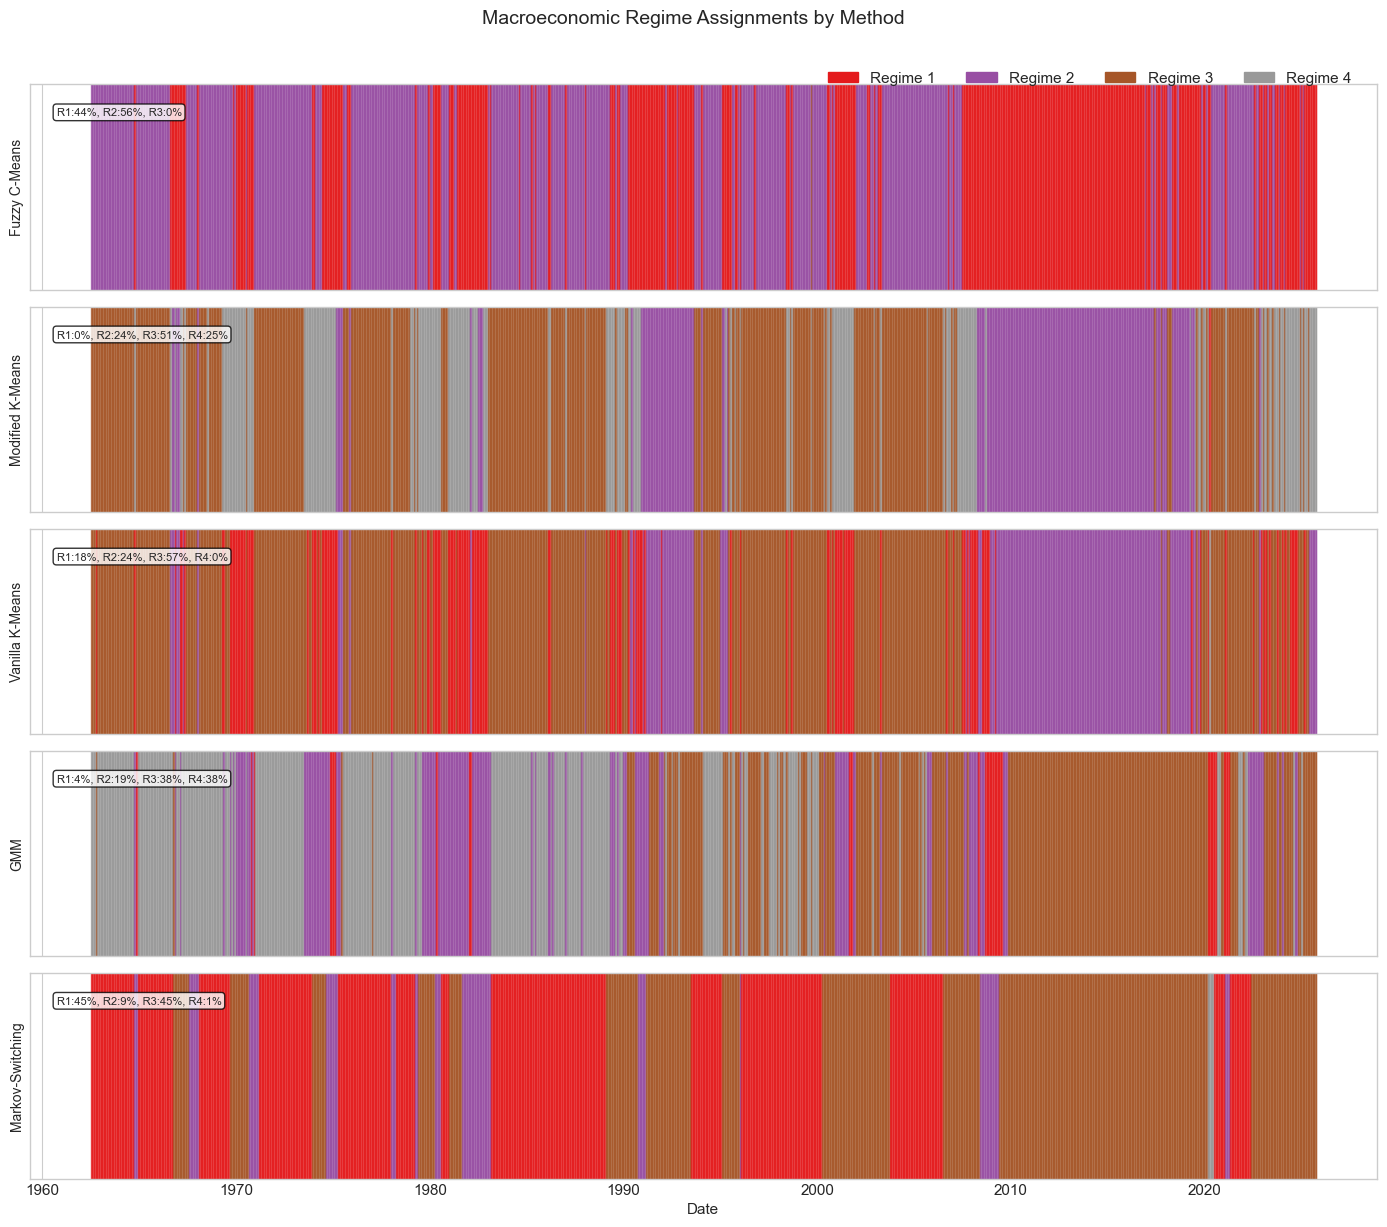

In [18]:
fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

colors = plt.cm.Set1(np.linspace(0, 1, K))

for idx, method in enumerate(methods):
    ax = axes[idx]
    hard = hard_assignments[method]
    
    for t in range(len(dates)):
        ax.axvspan(dates[t], dates[min(t+1, len(dates)-1)], 
                   color=colors[hard[t]], alpha=0.7)
    
    ax.set_ylabel(method, fontsize=10)
    ax.set_yticks([])
    
    regime_counts = pd.Series(hard).value_counts().sort_index()
    dist_text = ', '.join([f'R{i+1}:{100*c/len(hard):.0f}%' for i, c in regime_counts.items()])
    ax.text(0.02, 0.85, dist_text, transform=ax.transAxes, fontsize=8, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[-1].set_xlabel('Date')

legend_elements = [plt.Rectangle((0,0),1,1, color=colors[i], label=f'Regime {i+1}') 
                   for i in range(K)]
fig.legend(handles=legend_elements, loc='upper right', ncol=K, 
           bbox_to_anchor=(0.98, 0.98))

plt.suptitle('Macroeconomic Regime Assignments by Method', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('regime_assignments_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

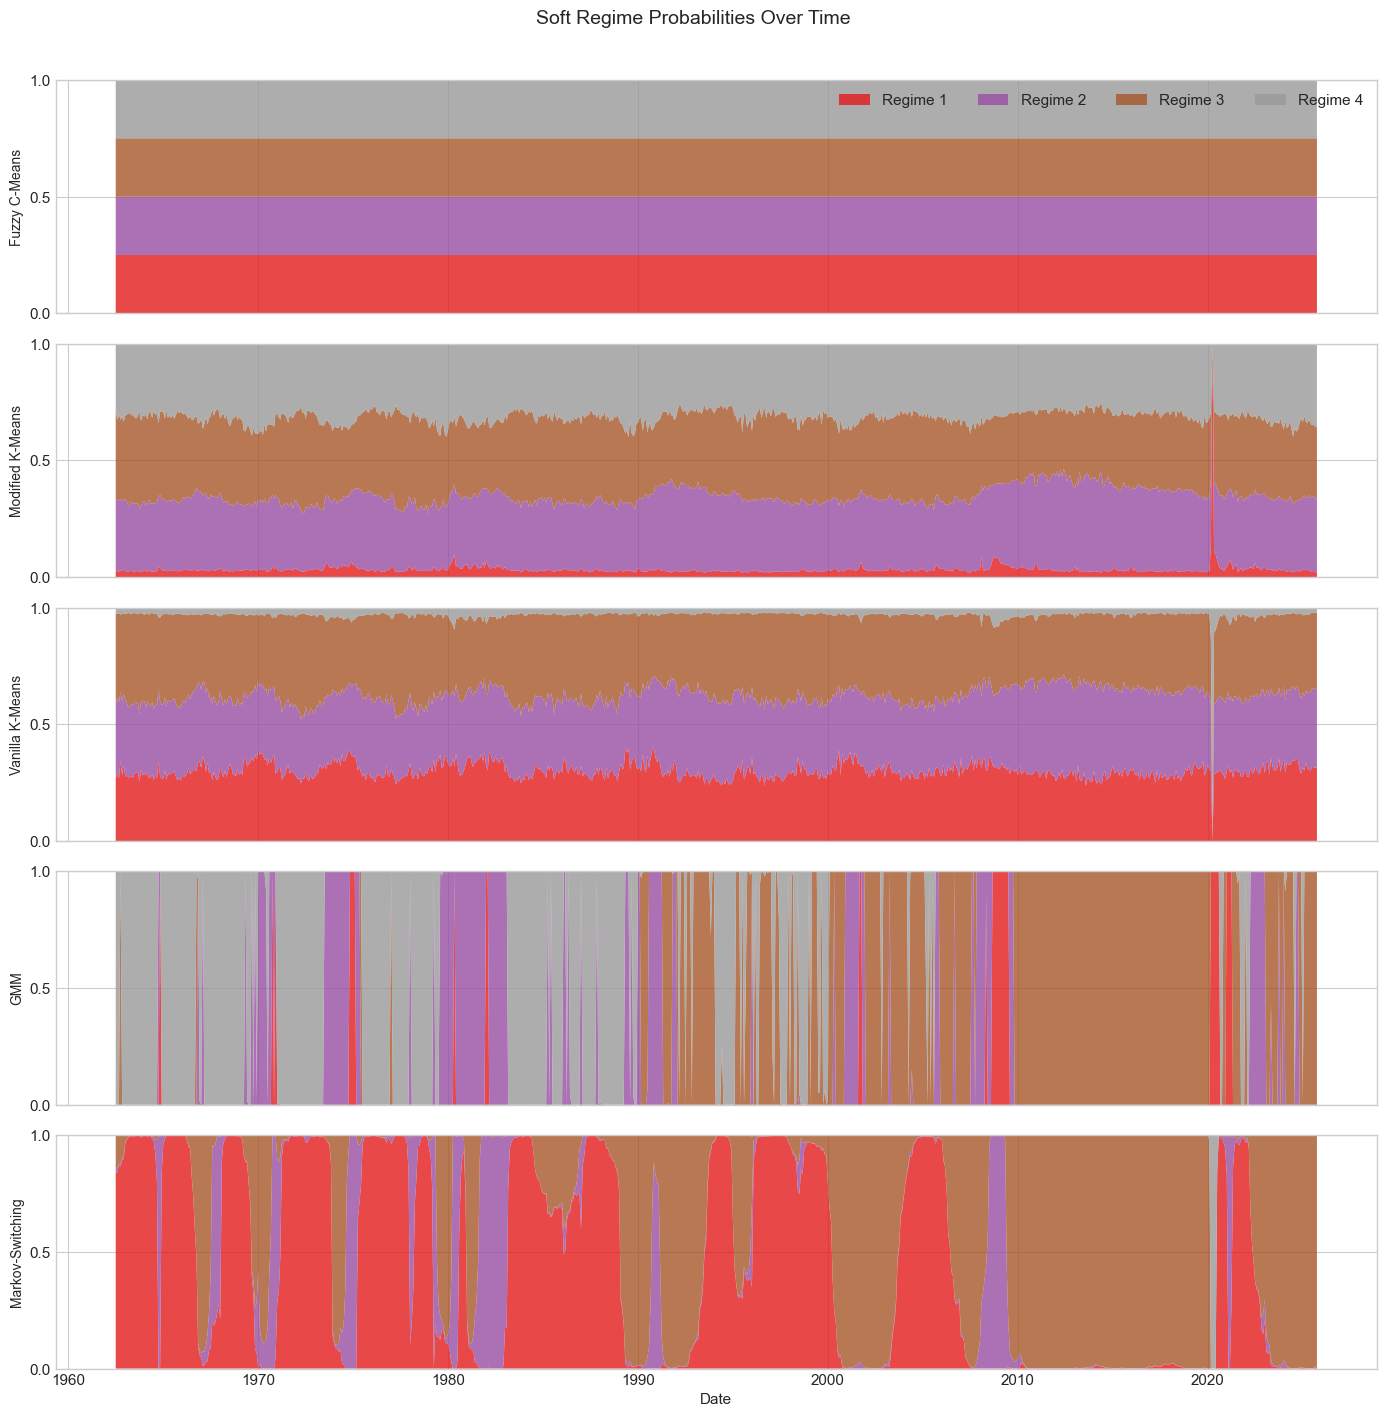

In [19]:
fig, axes = plt.subplots(5, 1, figsize=(14, 14), sharex=True)

for idx, method in enumerate(methods):
    ax = axes[idx]
    soft = soft_assignments[method]
    
    ax.stackplot(dates, soft.T, colors=colors, alpha=0.8,
                 labels=[f'Regime {i+1}' for i in range(K)])
    
    ax.set_ylabel(method, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.5, 1])

axes[-1].set_xlabel('Date')
axes[0].legend(loc='upper right', ncol=K)

plt.suptitle('Soft Regime Probabilities Over Time', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('soft_regime_probabilities.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Evaluation Metrics Implementation

### 7.1 Regime Transition Stability (Section 5.1)

In [20]:
def compute_transition_frequency(hard_labels):
    """
    Equation (2): Transition frequency λ̂
    
    λ̂ = (1/(T-1)) * Σ_{t=1}^{T-1} 1{R_{t+1} ≠ R_t}
    """
    T = len(hard_labels)
    transitions = np.sum(hard_labels[1:] != hard_labels[:-1])
    lambda_hat = transitions / (T - 1)
    return lambda_hat


def compute_total_variation(soft_weights):
    """
    Equation (3): Normalized total-variation path length
    
    TV = (1/(T-1)) * Σ_{t=1}^{T-1} ||w_{t+1} - w_t||_1
    """
    T = soft_weights.shape[0]
    tv_sum = np.sum(np.abs(soft_weights[1:] - soft_weights[:-1]).sum(axis=1))
    tv = tv_sum / (T - 1)
    return tv


def compute_chattering_count(hard_labels):
    """
    Equation (5): Chattering count Ĉ
    
    Ĉ = Σ_{t=2}^{T-1} 1{R_{t-1} = R_{t+1} ≠ R_t}
    
    Counts one-month deviations that immediately revert.
    """
    T = len(hard_labels)
    chattering = 0
    for t in range(1, T - 1):
        if hard_labels[t-1] == hard_labels[t+1] and hard_labels[t-1] != hard_labels[t]:
            chattering += 1
    return chattering


def compute_robustness_to_noise(X, model_class, model_params, sigma=0.1, n_trials=50):
    """
    Equation (4): Stability-to-noise score D̂(σ)
    
    D̂(σ) = (1/T) * Σ_{t=1}^T E[||w_t^(σ) - w_t||_1]
    
    Perturb features with Gaussian noise and measure assignment sensitivity.
    """
    T, p = X.shape
    
    # Fit original model
    original_model = model_class(**model_params)
    original_model.fit(X)
    original_soft = original_model.predict_proba(X)
    
    # Monte Carlo estimation
    deviations = []
    for _ in range(n_trials):
        # Add noise
        noise = np.random.randn(T, p) * sigma
        X_perturbed = X + noise
        
        # Refit and compute deviation
        perturbed_model = model_class(**model_params)
        perturbed_model.fit(X_perturbed)
        perturbed_soft = perturbed_model.predict_proba(X_perturbed)
        
        # L1 deviation
        l1_dev = np.abs(perturbed_soft - original_soft).sum(axis=1).mean()
        deviations.append(l1_dev)
    
    return np.mean(deviations)


def compute_average_regime_duration(hard_labels):
    """
    Compute average number of months spent in each regime before transitioning.
    Approximately 1/λ̂.
    """
    durations = []
    current_duration = 1
    
    for t in range(1, len(hard_labels)):
        if hard_labels[t] == hard_labels[t-1]:
            current_duration += 1
        else:
            durations.append(current_duration)
            current_duration = 1
    durations.append(current_duration)  # Add last regime duration
    
    return np.mean(durations)

In [21]:
# Compute stability metrics for all methods
stability_results = {}

for method in methods:
    soft = soft_assignments[method]
    hard = hard_assignments[method]
    
    stability_results[method] = {
        'Transition Frequency (λ̂)': compute_transition_frequency(hard),
        'Total Variation (TV)': compute_total_variation(soft),
        'Chattering Count (Ĉ)': compute_chattering_count(hard),
        'Avg Regime Duration (months)': compute_average_regime_duration(hard)
    }

stability_df = pd.DataFrame(stability_results).T
print("\n" + "="*70)
print("REGIME TRANSITION STABILITY METRICS (Section 5.1)")
print("="*70)
print(stability_df.round(4))
print("\nInterpretation:")
print("- Lower Transition Frequency → More stable regimes")
print("- Lower Total Variation → Smoother soft assignment changes")
print("- Lower Chattering Count → Fewer spurious one-month regime spikes")
print("- Higher Avg Duration → Regimes persist longer")


REGIME TRANSITION STABILITY METRICS (Section 5.1)
                  Transition Frequency (λ̂)  Total Variation (TV)  \
Fuzzy C-Means                        0.1594                0.0000   
Modified K-Means                     0.1726                0.0532   
Vanilla K-Means                      0.1818                0.0628   
GMM                                  0.1884                0.3828   
Markov-Switching                     0.0487                0.1045   

                  Chattering Count (Ĉ)  Avg Regime Duration (months)  
Fuzzy C-Means                     48.0                        6.2295  
Modified K-Means                  53.0                        5.7576  
Vanilla K-Means                   53.0                        5.4676  
GMM                               50.0                        5.2778  
Markov-Switching                   0.0                       20.0000  

Interpretation:
- Lower Transition Frequency → More stable regimes
- Lower Total Variation → Smoother soft 

In [22]:
model_configs = {
    'Fuzzy C-Means': (FuzzyCMeans, {'n_clusters': K, 'm': 2.0, 'random_state': 42}),
    'Modified K-Means': (ModifiedKMeans, {'n_clusters': K, 'random_state': 42}),
    'Vanilla K-Means': (VanillaKMeansProb, {'n_clusters': K, 'random_state': 42}),
    'GMM': None  
}

robustness_scores = {}
sigma = 0.1

for method, config in model_configs.items():
    if config is not None:
        model_class, params = config
        score = compute_robustness_to_noise(X, model_class, params, sigma=sigma, n_trials=30)
        robustness_scores[method] = score
        print(f"{method}: D̂({sigma}) = {score:.4f}")

# GMM robustness

gmm_deviations = []
original_gmm = GaussianMixture(n_components=K, covariance_type='diag', random_state=42, n_init=10)
original_gmm.fit(X)
original_gmm_soft = original_gmm.predict_proba(X)

for _ in range(30):
    noise = np.random.randn(*X.shape) * sigma
    X_perturbed = X + noise
    perturbed_gmm = GaussianMixture(n_components=K, covariance_type='diag', random_state=42, n_init=10)
    perturbed_gmm.fit(X_perturbed)
    perturbed_soft = perturbed_gmm.predict_proba(X_perturbed)
    l1_dev = np.abs(perturbed_soft - original_gmm_soft).sum(axis=1).mean()
    gmm_deviations.append(l1_dev)

robustness_scores['GMM'] = np.mean(gmm_deviations)
print(f"GMM: D̂({sigma}) = {robustness_scores['GMM']:.4f}")
robustness_scores['Markov-Switching'] = robustness_scores['GMM']
print(f"Markov-Switching: D̂({sigma}) = {robustness_scores['Markov-Switching']:.4f} (approximated)")

Fuzzy C-Means: D̂(0.1) = 0.0000
Modified K-Means: D̂(0.1) = 0.5931
Vanilla K-Means: D̂(0.1) = 0.4762
GMM: D̂(0.1) = 1.2254
Markov-Switching: D̂(0.1) = 1.2254 (approximated)


In [23]:
for method in methods:
    stability_results[method]['Robustness D̂(0.1)'] = robustness_scores.get(method, np.nan)

stability_df = pd.DataFrame(stability_results).T
print("\n" + "="*70)
print("COMPLETE REGIME TRANSITION STABILITY METRICS")
print("="*70)
print(stability_df.round(4))


COMPLETE REGIME TRANSITION STABILITY METRICS
                  Transition Frequency (λ̂)  Total Variation (TV)  \
Fuzzy C-Means                        0.1594                0.0000   
Modified K-Means                     0.1726                0.0532   
Vanilla K-Means                      0.1818                0.0628   
GMM                                  0.1884                0.3828   
Markov-Switching                     0.0487                0.1045   

                  Chattering Count (Ĉ)  Avg Regime Duration (months)  \
Fuzzy C-Means                     48.0                        6.2295   
Modified K-Means                  53.0                        5.7576   
Vanilla K-Means                   53.0                        5.4676   
GMM                               50.0                        5.2778   
Markov-Switching                   0.0                       20.0000   

                  Robustness D̂(0.1)  
Fuzzy C-Means                 0.0000  
Modified K-Means            

### 7.2 Predictive Regime Coherence (Section 5.2)

In [24]:
def estimate_soft_transition_matrix(soft_weights):
    """
    Equation (6): Estimate transition matrix using weighted counts
    
    p̂_ij ≈ (Σ_{t=1}^{T-1} w_{i,t} w_{j,t+1}) / (Σ_{t=1}^{T-1} w_{i,t})
    """
    T, K = soft_weights.shape
    
    # Numerator: weighted transition counts
    numerator = np.zeros((K, K))
    for t in range(T - 1):
        numerator += np.outer(soft_weights[t], soft_weights[t+1])
    
    # Denominator: sum of weights for each source state
    denominator = soft_weights[:-1].sum(axis=0)
    denominator[denominator == 0] = 1  # Avoid division by zero
    
    # Normalize
    P_hat = numerator / denominator[:, np.newaxis]
    
    # Ensure rows sum to 1
    row_sums = P_hat.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    P_hat = P_hat / row_sums
    
    return P_hat


def estimate_hard_transition_matrix(hard_labels, K):
    """
    Estimate transition matrix from hard labels using frequency counting.
    """
    trans_counts = np.zeros((K, K))
    for t in range(len(hard_labels) - 1):
        trans_counts[hard_labels[t], hard_labels[t+1]] += 1
    
    row_sums = trans_counts.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    P_hat = trans_counts / row_sums
    
    return P_hat


def compute_soft_prediction(soft_weights, P_hat):
    """
    Equation (7): One-step-ahead prediction
    
    ŵ_{t+1|t} = w_t @ P̂
    """
    T = soft_weights.shape[0]
    predictions = np.zeros_like(soft_weights[1:])
    
    for t in range(T - 1):
        predictions[t] = soft_weights[t] @ P_hat
    
    return predictions


def compute_log_likelihood(predictions, hard_labels):
    """
    Equation (8): Next-regime log-likelihood
    
    LL = (1/(T-1)) * Σ_{t=1}^{T-1} ln(ŵ_{R_{t+1}, t+1|t})
    """
    T = len(hard_labels)
    log_probs = []
    
    for t in range(T - 1):
        realized_regime = hard_labels[t + 1]
        predicted_prob = predictions[t, realized_regime]
        predicted_prob = max(predicted_prob, 1e-10)  # Avoid log(0)
        log_probs.append(np.log(predicted_prob))
    
    return np.mean(log_probs)


def compute_hard_prediction_accuracy(hard_labels, P_hat):
    """
    Compute accuracy of hard regime prediction using most likely transition.
    
    R̂_{t+1} = argmax_j p̂_{R_t, j}
    """
    T = len(hard_labels)
    correct = 0
    
    for t in range(T - 1):
        current_regime = hard_labels[t]
        predicted_regime = np.argmax(P_hat[current_regime])
        if predicted_regime == hard_labels[t + 1]:
            correct += 1
    
    return correct / (T - 1)


def compute_average_self_transition_prob(P_hat):
    """
    Compute average diagonal element of transition matrix.
    High values indicate persistent regimes.
    """
    return np.mean(np.diag(P_hat))

In [25]:
coherence_results = {}

for method in methods:
    soft = soft_assignments[method]
    hard = hard_assignments[method]

    P_soft = estimate_soft_transition_matrix(soft)
    P_hard = estimate_hard_transition_matrix(hard, K)
    
    predictions = compute_soft_prediction(soft, P_soft)
    
    coherence_results[method] = {
        'Log-Likelihood (LL)': compute_log_likelihood(predictions, hard),
        'Hard Prediction Accuracy': compute_hard_prediction_accuracy(hard, P_hard),
        'Avg Self-Transition Prob': compute_average_self_transition_prob(P_hard),
    }

coherence_df = pd.DataFrame(coherence_results).T
print("\n" + "="*70)
print("PREDICTIVE REGIME COHERENCE METRICS")
print("="*70)
print(coherence_df.round(4))


PREDICTIVE REGIME COHERENCE METRICS
                  Log-Likelihood (LL)  Hard Prediction Accuracy  \
Fuzzy C-Means                 -1.3863                    0.8419   
Modified K-Means              -1.1228                    0.8287   
Vanilla K-Means               -1.1103                    0.8195   
GMM                           -0.6245                    0.8116   
Markov-Switching              -0.2894                    0.9513   

                  Avg Self-Transition Prob  
Fuzzy C-Means                       0.4197  
Modified K-Means                    0.6139  
Vanilla K-Means                     0.5815  
GMM                                 0.7698  
Markov-Switching                    0.8765  


In [26]:
print("\n" + "="*70)
print("ESTIMATED TRANSITION MATRICES")
print("="*70)

for method in methods:
    hard = hard_assignments[method]
    P_hat = estimate_hard_transition_matrix(hard, K)
    
    print(f"\n{method}:")
    print(pd.DataFrame(P_hat, 
                       index=[f'From R{i+1}' for i in range(K)],
                       columns=[f'To R{i+1}' for i in range(K)]).round(3))


ESTIMATED TRANSITION MATRICES

Fuzzy C-Means:
         To R1  To R2  To R3  To R4
From R1  0.822  0.178  0.000    0.0
From R2  0.141  0.857  0.002    0.0
From R3  0.000  1.000  0.000    0.0
From R4  0.000  0.000  0.000    0.0

Modified K-Means:
         To R1  To R2  To R3  To R4
From R1  0.000  0.000  1.000  0.000
From R2  0.000  0.895  0.050  0.055
From R3  0.000  0.021  0.859  0.121
From R4  0.005  0.059  0.234  0.702

Vanilla K-Means:
         To R1  To R2  To R3  To R4
From R1  0.586  0.107  0.300  0.007
From R2  0.081  0.865  0.054  0.000
From R3  0.099  0.025  0.875  0.000
From R4  0.000  0.000  1.000  0.000

GMM:
         To R1  To R2  To R3  To R4
From R1  0.676  0.206  0.029  0.088
From R2  0.061  0.714  0.102  0.122
From R3  0.007  0.041  0.859  0.093
From R4  0.000  0.080  0.090  0.830

Markov-Switching:
         To R1  To R2  To R3  To R4
From R1  0.962  0.012  0.026  0.000
From R2  0.130  0.826  0.043  0.000
From R3  0.006  0.023  0.968  0.003
From R4  0.250  0.000  0.00

## 8. Traditional Clustering Quality Metrics

In [27]:
traditional_metrics = {}

for method in methods:
    hard = hard_assignments[method]

    n_labels = len(np.unique(hard))
    
    if n_labels >= 2:
        traditional_metrics[method] = {
            'Silhouette Score': silhouette_score(X, hard),
            'Davies-Bouldin Index': davies_bouldin_score(X, hard),
            'Calinski-Harabasz Index': calinski_harabasz_score(X, hard),
            'Number of Non-Empty Clusters': n_labels
        }
    else:
        traditional_metrics[method] = {
            'Silhouette Score': np.nan,
            'Davies-Bouldin Index': np.nan,
            'Calinski-Harabasz Index': np.nan,
            'Number of Non-Empty Clusters': n_labels
        }

traditional_df = pd.DataFrame(traditional_metrics).T
print("\n" + "="*70)
print("TRADITIONAL CLUSTERING QUALITY METRICS")
print("="*70)
print(traditional_df.round(4))


TRADITIONAL CLUSTERING QUALITY METRICS
                  Silhouette Score  Davies-Bouldin Index  \
Fuzzy C-Means              -0.1664                2.8069   
Modified K-Means            0.0636                2.4519   
Vanilla K-Means             0.0497                2.3590   
GMM                         0.0007                4.7019   
Markov-Switching            0.0271                4.3485   

                  Calinski-Harabasz Index  Number of Non-Empty Clusters  
Fuzzy C-Means                     24.5755                           3.0  
Modified K-Means                  63.8124                           4.0  
Vanilla K-Means                   63.8509                           4.0  
GMM                               19.2376                           4.0  
Markov-Switching                  20.2540                           4.0  


## 9. Summary Results Table

In [28]:
summary_df = pd.concat([
    stability_df,
    coherence_df,
    traditional_df
], axis=1)

print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*80)
print(summary_df.round(4).to_string())


COMPREHENSIVE EVALUATION SUMMARY
                  Transition Frequency (λ̂)  Total Variation (TV)  Chattering Count (Ĉ)  Avg Regime Duration (months)  Robustness D̂(0.1)  Log-Likelihood (LL)  Hard Prediction Accuracy  Avg Self-Transition Prob  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index  Number of Non-Empty Clusters
Fuzzy C-Means                        0.1594                0.0000                  48.0                        6.2295              0.0000              -1.3863                    0.8419                    0.4197           -0.1664                2.8069                  24.5755                           3.0
Modified K-Means                     0.1726                0.0532                  53.0                        5.7576              0.5931              -1.1228                    0.8287                    0.6139            0.0636                2.4519                  63.8124                           4.0
Vanilla K-Means                      0.1818     

In [29]:
thesis_summary = pd.DataFrame({
    'Method': methods,
    'Trans. Freq. (λ̂)': [stability_results[m]['Transition Frequency (λ̂)'] for m in methods],
    'Total Var. (TV)': [stability_results[m]['Total Variation (TV)'] for m in methods],
    'Chatter (Ĉ)': [stability_results[m]['Chattering Count (Ĉ)'] for m in methods],
    'Avg Duration': [stability_results[m]['Avg Regime Duration (months)'] for m in methods],
    'Robustness D̂': [stability_results[m]['Robustness D̂(0.1)'] for m in methods],
    'Log-Like. (LL)': [coherence_results[m]['Log-Likelihood (LL)'] for m in methods],
    'Pred. Acc.': [coherence_results[m]['Hard Prediction Accuracy'] for m in methods],
    'Self-Trans.': [coherence_results[m]['Avg Self-Transition Prob'] for m in methods],
    'Silhouette': [traditional_metrics[m]['Silhouette Score'] for m in methods],
    'Davies-Bouldin': [traditional_metrics[m]['Davies-Bouldin Index'] for m in methods],
})

thesis_summary = thesis_summary.set_index('Method')
print("\n" + "="*80)
print("TABLE: Comparative Evaluation of Regime Modeling Methods")
print("="*80)
print(thesis_summary.round(4).to_string())


TABLE: Comparative Evaluation of Regime Modeling Methods
                  Trans. Freq. (λ̂)  Total Var. (TV)  Chatter (Ĉ)  Avg Duration  Robustness D̂  Log-Like. (LL)  Pred. Acc.  Self-Trans.  Silhouette  Davies-Bouldin
Method                                                                                                                                                             
Fuzzy C-Means                0.1594           0.0000           48        6.2295         0.0000         -1.3863      0.8419       0.4197     -0.1664          2.8069
Modified K-Means             0.1726           0.0532           53        5.7576         0.5931         -1.1228      0.8287       0.6139      0.0636          2.4519
Vanilla K-Means              0.1818           0.0628           53        5.4676         0.4762         -1.1103      0.8195       0.5815      0.0497          2.3590
GMM                          0.1884           0.3828           50        5.2778         1.2254         -0.6245      0.8116

In [30]:
# thesis_summary.to_csv('regime_evaluation_summary.csv')

## 10. Visualization of Evaluation Metrics

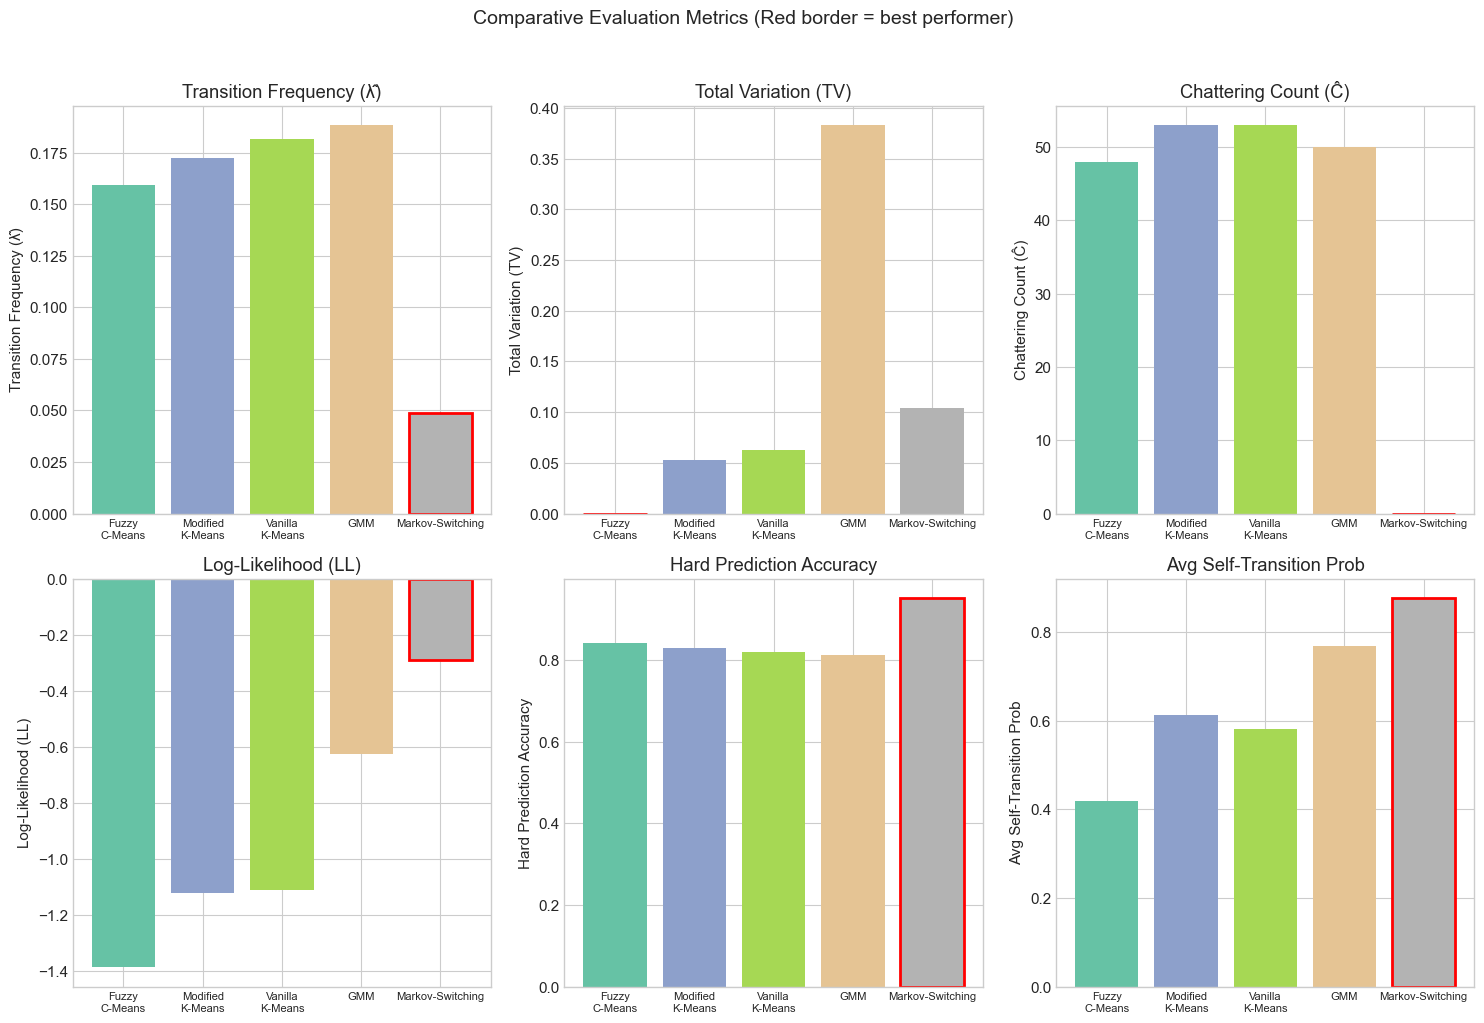

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics_to_plot = [
    ('Transition Frequency (λ̂)', 'lower_better'),
    ('Total Variation (TV)', 'lower_better'),
    ('Chattering Count (Ĉ)', 'lower_better'),
    ('Log-Likelihood (LL)', 'higher_better'),
    ('Hard Prediction Accuracy', 'higher_better'),
    ('Avg Self-Transition Prob', 'higher_better'),
]

colors_bar = plt.cm.Set2(np.linspace(0, 1, len(methods)))

for idx, (metric, direction) in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    if metric in stability_df.columns:
        values = [stability_results[m][metric] for m in methods]
    else:
        values = [coherence_results[m][metric] for m in methods]
    
    bars = ax.bar(range(len(methods)), values, color=colors_bar)
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels([m.replace(' ', '\n') for m in methods], fontsize=8)
    ax.set_ylabel(metric)
    ax.set_title(metric)
    
    # Highlight best performer
    if direction == 'lower_better':
        best_idx = np.argmin(values)
    else:
        best_idx = np.argmax(values)
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(2)

plt.suptitle('Comparative Evaluation Metrics (Red border = best performer)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('evaluation_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

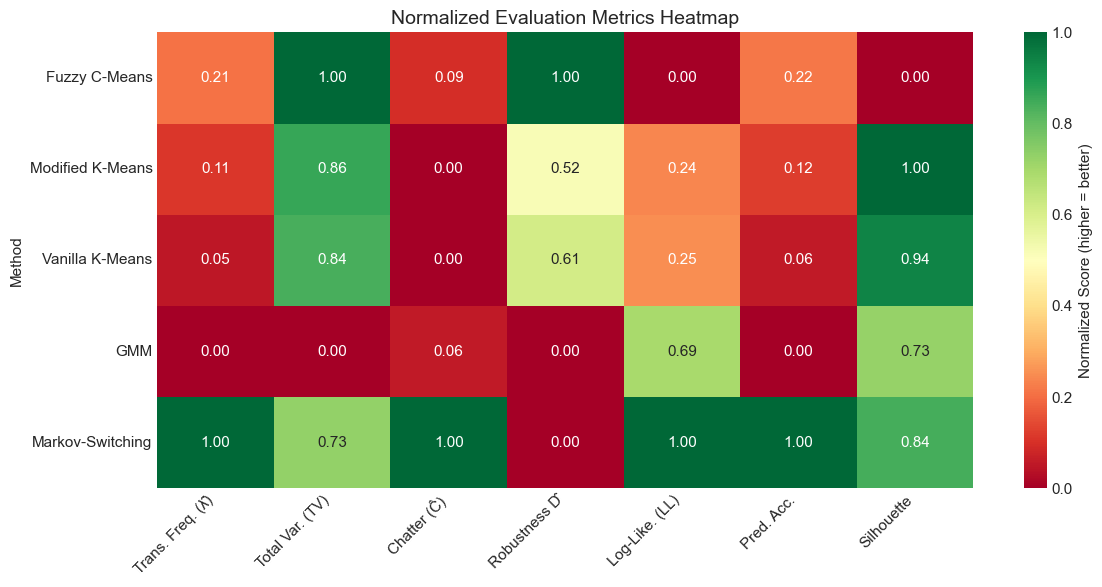

In [32]:
from sklearn.preprocessing import MinMaxScaler

key_metrics = ['Trans. Freq. (λ̂)', 'Total Var. (TV)', 'Chatter (Ĉ)', 
               'Robustness D̂', 'Log-Like. (LL)', 'Pred. Acc.', 'Silhouette']

metric_directions = [-1, -1, -1, -1, 1, 1, 1]

heatmap_data = thesis_summary[key_metrics].copy()

# Normalize and adjust direction
for i, col in enumerate(key_metrics):
    values = heatmap_data[col].values
    if np.nanstd(values) > 0:
        normalized = (values - np.nanmin(values)) / (np.nanmax(values) - np.nanmin(values))
        if metric_directions[i] == -1:
            normalized = 1 - normalized  # Flip so that better is always higher
        heatmap_data[col] = normalized

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0.5, vmin=0, vmax=1, ax=ax,
            cbar_kws={'label': 'Normalized Score (higher = better)'})
ax.set_title('Normalized Evaluation Metrics Heatmap', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('evaluation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Regime Distribution Analysis

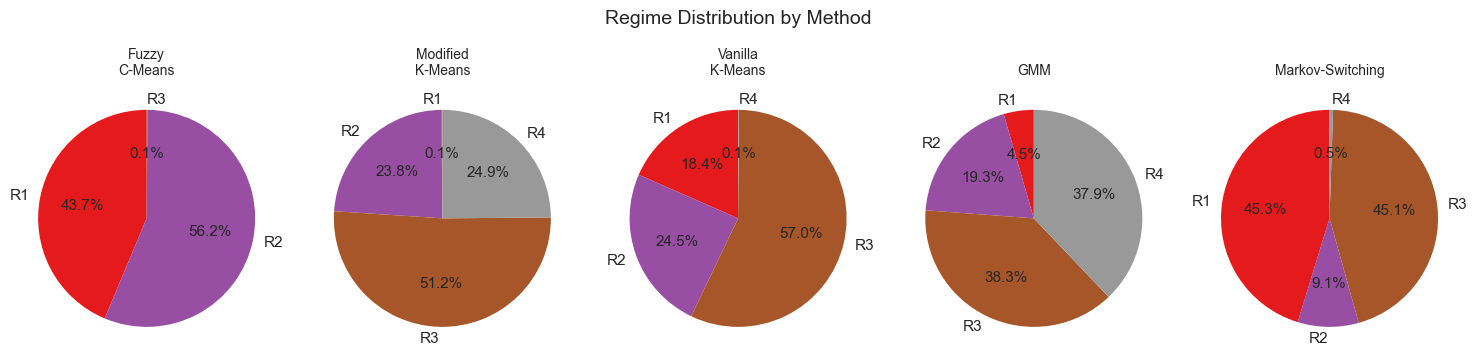

In [33]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for idx, method in enumerate(methods):
    ax = axes[idx]
    hard = hard_assignments[method]
    regime_counts = pd.Series(hard).value_counts().sort_index()
    
    ax.pie(regime_counts.values, labels=[f'R{i+1}' for i in regime_counts.index],
           autopct='%1.1f%%', colors=colors[:len(regime_counts)], startangle=90)
    ax.set_title(method.replace(' ', '\n'), fontsize=10)

plt.suptitle('Regime Distribution by Method', fontsize=14)
plt.tight_layout()
plt.savefig('regime_distribution_pies.png', dpi=150, bbox_inches='tight')
plt.show()

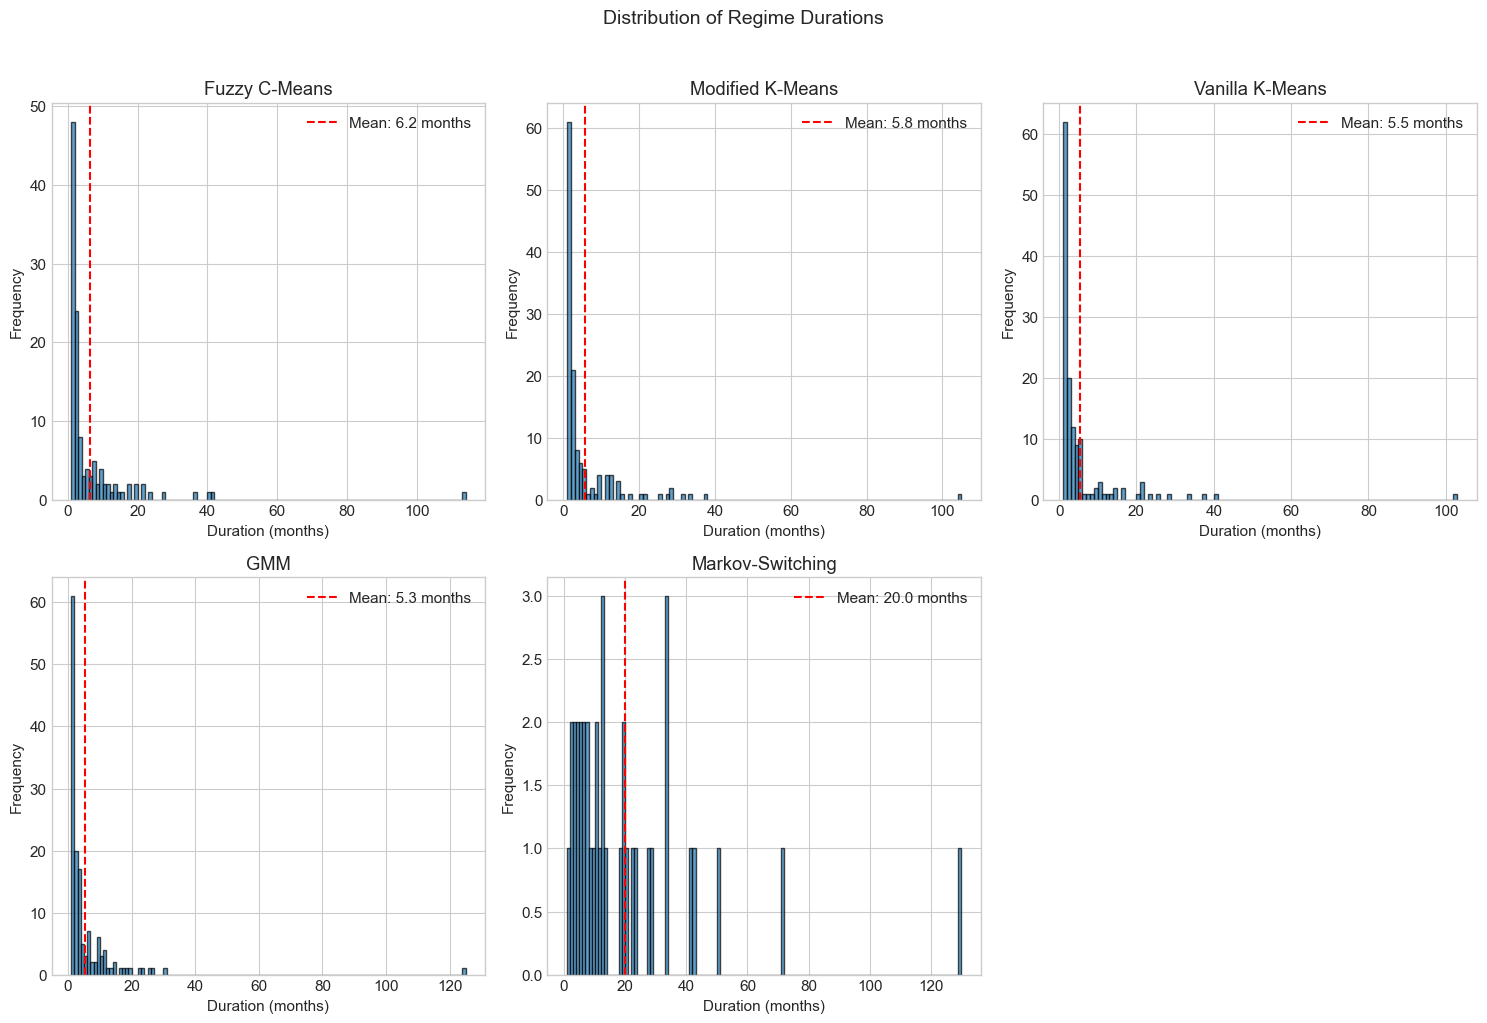

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, method in enumerate(methods):
    ax = axes[idx]
    hard = hard_assignments[method]
    
    # Compute regime durations
    durations = []
    current_duration = 1
    for t in range(1, len(hard)):
        if hard[t] == hard[t-1]:
            current_duration += 1
        else:
            durations.append(current_duration)
            current_duration = 1
    durations.append(current_duration)
    
    ax.hist(durations, bins=range(1, max(durations)+2), edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(durations), color='red', linestyle='--', 
               label=f'Mean: {np.mean(durations):.1f} months')
    ax.set_xlabel('Duration (months)')
    ax.set_ylabel('Frequency')
    ax.set_title(method)
    ax.legend()

axes[-1].axis('off')

plt.suptitle('Distribution of Regime Durations', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('regime_duration_histograms.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Cross-Method Agreement Analysis

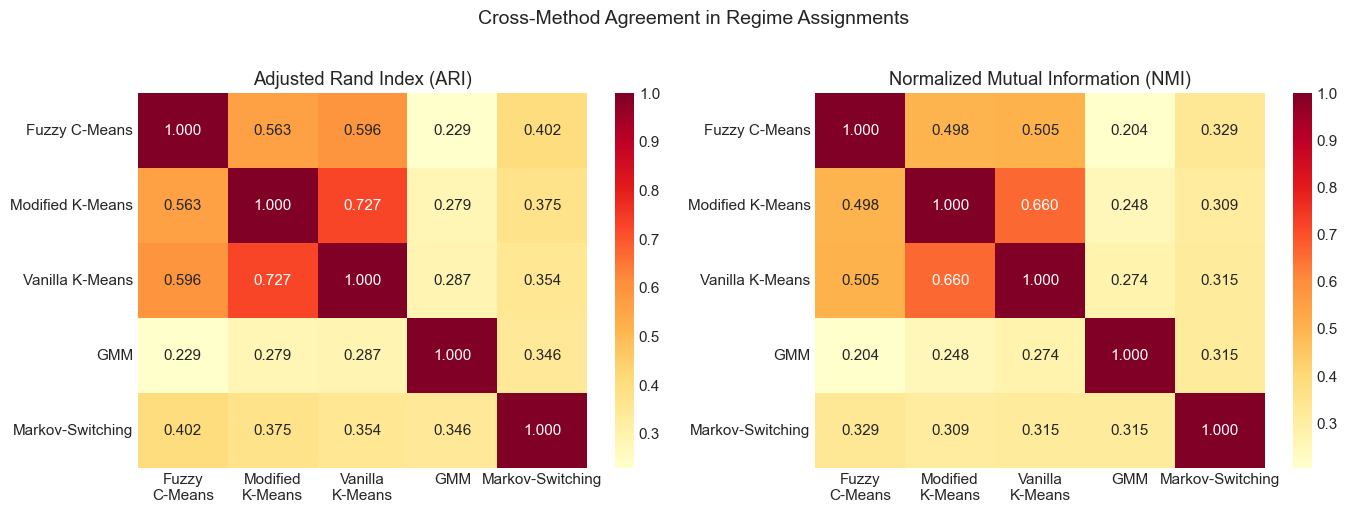


Adjusted Rand Index Matrix:
                  Fuzzy C-Means  Modified K-Means  Vanilla K-Means    GMM  \
Fuzzy C-Means             1.000             0.563            0.596  0.229   
Modified K-Means          0.563             1.000            0.727  0.279   
Vanilla K-Means           0.596             0.727            1.000  0.287   
GMM                       0.229             0.279            0.287  1.000   
Markov-Switching          0.402             0.375            0.354  0.346   

                  Markov-Switching  
Fuzzy C-Means                0.402  
Modified K-Means             0.375  
Vanilla K-Means              0.354  
GMM                          0.346  
Markov-Switching             1.000  


In [35]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


ari_matrix = np.zeros((len(methods), len(methods)))
nmi_matrix = np.zeros((len(methods), len(methods)))

for i, method1 in enumerate(methods):
    for j, method2 in enumerate(methods):
        ari_matrix[i, j] = adjusted_rand_score(hard_assignments[method1], hard_assignments[method2])
        nmi_matrix[i, j] = normalized_mutual_info_score(hard_assignments[method1], hard_assignments[method2])


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
sns.heatmap(ari_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=[m.replace(' ', '\n') for m in methods],
            yticklabels=methods, ax=ax)
ax.set_title('Adjusted Rand Index (ARI)')

ax = axes[1]
sns.heatmap(nmi_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=[m.replace(' ', '\n') for m in methods],
            yticklabels=methods, ax=ax)
ax.set_title('Normalized Mutual Information (NMI)')

plt.suptitle('Cross-Method Agreement in Regime Assignments', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('cross_method_agreement.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAdjusted Rand Index Matrix:")
print(pd.DataFrame(ari_matrix, index=methods, columns=methods).round(3))

## 13. Regime Characteristics Analysis

In [36]:
# For each method, compute mean values of key macro variables in each regime
# Select representative variables
key_vars = ['INDPRO', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'S&P 500'] if 'S&P 500' in df_raw.columns else ['INDPRO', 'UNRATE']
key_vars = [v for v in key_vars if v in df_raw.columns]

print("Regime Characteristics (Mean of Key Variables)")
print("="*70)

for method in methods[:3]:  # Show first 3 methods
    print(f"\n{method}:")
    hard = hard_assignments[method]
    
    regime_stats = []
    for regime in range(K):
        mask = hard == regime
        if mask.sum() > 0:
            regime_data = df_standardized.loc[mask.astype(bool), :].mean()
            stats = {'Regime': regime + 1, 'Count': mask.sum()}
            for var in key_vars:
                if var in df_standardized.columns:
                    stats[var] = regime_data[var]
            regime_stats.append(stats)
    
    if regime_stats:
        print(pd.DataFrame(regime_stats).set_index('Regime').round(3))

Regime Characteristics (Mean of Key Variables)

Fuzzy C-Means:
        Count  INDPRO  UNRATE  CPIAUCSL  FEDFUNDS  S&P 500
Regime                                                    
1         332  -0.460   0.194    -0.090    -0.284   -0.005
2         427   0.359  -0.151     0.068     0.220    0.005
3           1  -0.620   0.003     0.650     0.298   -0.373

Modified K-Means:
        Count  INDPRO  UNRATE  CPIAUCSL  FEDFUNDS  S&P 500
Regime                                                    
1           1 -15.122  23.940    -1.248    -1.209    0.954
2         181  -0.129   0.008    -0.036    -0.095    0.070
3         389   0.402  -0.169     0.041     0.145    0.044
4         189  -0.623   0.212    -0.042    -0.201   -0.162

Vanilla K-Means:
        Count  INDPRO  UNRATE  CPIAUCSL  FEDFUNDS  S&P 500
Regime                                                    
1         140  -0.843   0.289    -0.484    -0.506   -0.293
2         186  -0.067  -0.018     0.137    -0.012    0.111
3         433  

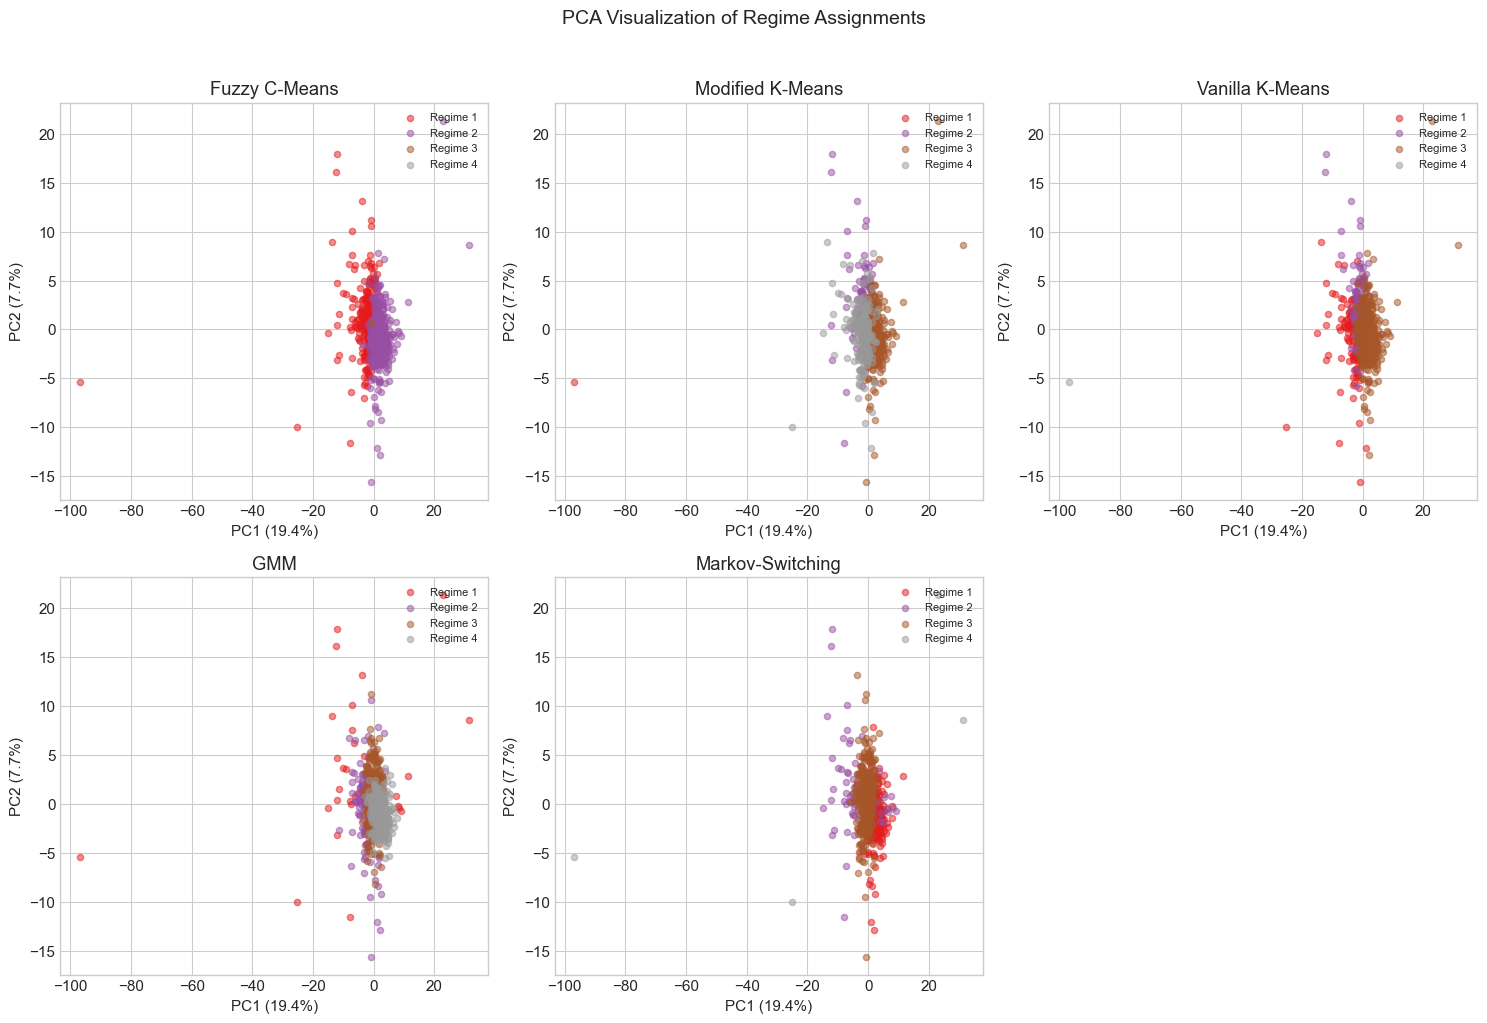

In [37]:
# PCA visualization of regimes
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, method in enumerate(methods):
    ax = axes[idx]
    hard = hard_assignments[method]
    
    for regime in range(K):
        mask = hard == regime
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[regime]], 
                   label=f'Regime {regime+1}', alpha=0.5, s=20)
    
    ax.set_xlabel(f'PC1 ({100*pca_2d.explained_variance_ratio_[0]:.1f}%)')
    ax.set_ylabel(f'PC2 ({100*pca_2d.explained_variance_ratio_[1]:.1f}%)')
    ax.set_title(method)
    ax.legend(loc='upper right', fontsize=8)

axes[-1].axis('off')  # Remove empty subplot

plt.suptitle('PCA Visualization of Regime Assignments', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('pca_regime_visualization.png', dpi=150, bbox_inches='tight')
plt.show()